In [1]:
import numpy as np
import time
np.set_printoptions(precision=6)
import copy
#utilizaremos o pandas para lidar com o arquivo csv do dataset
import pandas as pd
#utilizaremos funções utilitárias do scikit learn para preparar os dados
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit
#utilizaremos o matplotlib para exibir gráficos
import matplotlib.pyplot as plt
#utilizaremos o tensorboard para visualizar o desempenho do treinamento das redes
from torch.utils.tensorboard import SummaryWriter

#utilizaremos o pytorch como biblioteca para a rede neural
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#importamos o dataset (previamente baixado do Kaggle) e exibimos suas 5 primeiras linhas 
#com a função "head"
skyserver_df = pd.read_csv('input/Skyserver_SQL2_27_2018 6_51_39 PM.csv')
skyserver_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


Text(0.5, 1.0, 'Matriz de Correlação')

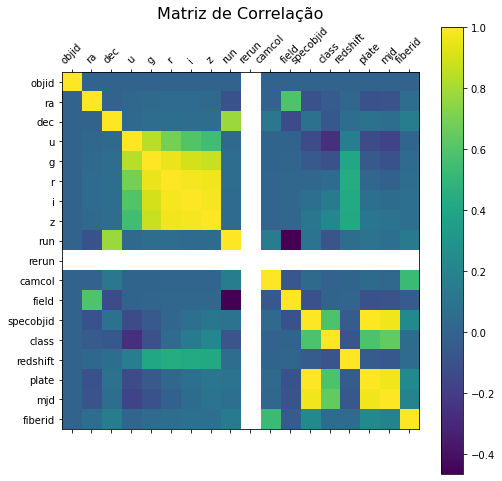

In [3]:
#criamos uma copia do dataset para exibir a matriz de correlação
correlation_skyserver_df = copy.deepcopy(skyserver_df)

#usamos LabelEncoder para transformar as classes categóricas em numéricas
le = LabelEncoder()
#o LabelEncoder é então aplicado sobre a cópia do dataset
correlation_skyserver_df['class'] = le.fit_transform(skyserver_df['class'])
#criamos a matriz de correlação
correlation_matrix = correlation_skyserver_df.corr()

#f define a figura e seu tamanho
f = plt.figure(figsize=(8, 8))
#matshow define os dados do grafico a ser exibido
plt.matshow(correlation_matrix, fignum=f.number)
#legenda do eixo x
plt.xticks(range(correlation_skyserver_df.select_dtypes(['number']).shape[1]), correlation_skyserver_df.select_dtypes(['number']).columns, fontsize=10, rotation=45)
#legenda do eixo y
plt.yticks(range(correlation_skyserver_df.select_dtypes(['number']).shape[1]), correlation_skyserver_df.select_dtypes(['number']).columns, fontsize=10)
#colorbar instancia uma barra de legenda para melhor visualização
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#colocamos um título no gráfico
plt.title('Matriz de Correlação', fontsize=16)

In [4]:
#exibimos os valores de correlação das variáveis do dataset com a classe
with pd.option_context('display.float_format', '{:0.6f}'.format):
    print(correlation_matrix['class'])

objid       -0.000000
ra          -0.043219
dec         -0.058918
u           -0.269044
g           -0.099212
r            0.049628
i            0.146791
z            0.215758
run         -0.078162
rerun             nan
camcol      -0.006186
field        0.007713
specobjid    0.585493
class        1.000000
redshift    -0.075510
plate        0.585495
mjd          0.648768
fiberid      0.053593
Name: class, dtype: float64


In [5]:
#eliminamos as colunas com dados irrelevantes à classificação
skyserver_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'mjd'], axis=1, inplace=True)

In [6]:
#usamos LabelEncoder para transformar as classes categóricas em numéricas
le = LabelEncoder()
#o LabelEncoder é aplicado sobre o dataset
y_numerical_classes = le.fit_transform(skyserver_df['class'])
#visto que as classes estão na variável y_encoded, podemos eliminar a coluna "class" do dataset
skyserver_df.drop(['class'], axis=1, inplace=True)

y_numerical_classes = y_numerical_classes.reshape(-1, 1)

In [7]:
#visto que será utilizada a função softmax, transformamos as classes em vetores one-hot
enc = OneHotEncoder()
enc.fit(y_numerical_classes)

#aplicamos o OneHotEncoder ao vetor de categorias na forma numérica criado anteriormente
y_encoded = enc.transform(y_numerical_classes)
y_encoded = y_encoded.toarray().tolist()

In [8]:
#normalizamos os parâmetros do dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
skyserver_normalized = scaler.fit_transform(skyserver_df).tolist()

In [9]:
#a função stitch une em uma mesma lista os parametros de treino (x) e a categoria (y)
def stitch(inputs, target):
    series_inputs = pd.Series(inputs)
    series_target = pd.Series(target)
    df = pd.DataFrame({'inputs': series_inputs, 'target': series_target})
    return df.values.tolist()

#já a função unstitch separa os atributos da label, fazendo o oposto da função stitch
def unstitch(data):
    df = pd.DataFrame(data)
    return df[0].values.tolist(), df[1].values.tolist()

In [10]:
#unimos os parametros de treino (x) com as categorias (y) em uma única lista com a função stitch
data = stitch(skyserver_normalized, y_encoded)

In [11]:
#separamos o dataset original nos conjuntos de treino, validação e teste
#o conjunto de treino ficou com 60% dos exemplos, enquanto o de validação ficou com 20%,
#e o de testes também com 20%
train, test = train_test_split(data, test_size=0.2, shuffle=True)
train, val = train_test_split(train, test_size=0.25, shuffle=True)

In [12]:
device = "cpu"

#a classe Net, abaixo, define no PyTorch como será a arquitetura da rede neural
class Net(nn.Module):
    #em __init__ definimos cada uma das camadas
    def __init__(self, activate_dropout=False, weightDecay=0):
        super(Net, self).__init__()
        #fc1 corresponde à camada de entrada e terá 20 neurônios
        self.fc1 = nn.Linear(10, 20)
        #preparamos uma camada de dropout que pode ou não ser utilizada no treinamento, conforme
        #parametro "activate_dropout"
        self.do1 = nn.Dropout(p=DROPOUT_RATE)
        #a função de ativação utilizada para cada neurônio é tanh
        self.rl1 = nn.Tanh()
        #fc2 corresponde à camada oculta, também tendo 20 neurônios
        self.fc2 = nn.Linear(20, 20)
        self.do2 = nn.Dropout(p=DROPOUT_RATE)
        self.rl2 = nn.Tanh()
        #já fc3 corresponde à cama de saída, com apenas 3 neurônios, visto que lidamos com
        #3 classes na classificação
        self.fc3 = nn.Linear(20, 3)
        self.do3 = nn.Dropout(p=DROPOUT_RATE)
        #a função de saída será softmax, recomendado para casos de classificação com múltiplas
        #classes
        self.smout = nn.Softmax(dim=1)      
        
        #a função de loss utilizada é L1 (MAE, ou erro absoluto médio)
        self.criterion = nn.L1Loss()
        #o otimizador selecionado foi Adam
        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.activate_dropout=activate_dropout
    
    def forward(self, x):
        #o PyTorch requer que o forward propagation seja declarado para cada camada
        x = self.fc1(x)
        if self.activate_dropout:
            x = self.do1(x)
        x = self.rl1(x)
        x = self.fc2(x)
        if self.activate_dropout:
            x = self.do2(x)
        x = self.rl2(x)
        x = self.fc3(x)
        if self.activate_dropout:
            x = self.do3(x)
        x = self.smout(x)
        return x
       
    def store_results(self, epoch, train):
        #função criada para gerar os gráficos do TensorBoard
        if STORE_RESULT and epoch%REPORT_RATE==0:
            writer.add_scalar('Accuracy/train', self.accuracy(train), epoch)
            writer.add_scalar('Accuracy/val', self.accuracy(val), epoch)

    def print_final_train_acc(self, epoch, train):
        #função para exibir acurácia final
        if epoch==NUM_EPOCHS-1:
            print(f"Final training accuracy: {self.accuracy(train)}")

    def train(self, numEpochs, train):
        #função que realiza o treino da rede
        #o treino inicia com a separação dos parâmetros e das labels
        inputs, labels = unstitch(train)
        
        inputs = Variable(torch.FloatTensor(inputs))
        labels = Variable(torch.FloatTensor(labels))

        #em seguida, para cada época é realizado o forward propagation, e então o otimizador
        #efetua o back propagation atualizando os pesos de cada neurônio
        #os resultados de cada época são armazenados para exibição no TensorBoard
        for epoch in range(numEpochs):
            self.optimizer.zero_grad()
            outputs = self(inputs)
            self.loss = self.criterion(outputs, labels)
            self.loss.backward()    
            self.optimizer.step()

            self.store_results(epoch, train)
            self.print_final_train_acc(epoch, train)

    def loss(self, loss_set):
        #a função de loss é definida
        inputs, labels = unstitch(loss_set)
        inputs = Variable(torch.FloatTensor(inputs))
        labels = Variable(torch.FloatTensor(labels))
        result = self(inputs)
        loss = self.criterion(result, torch.max(labels, 1)[1])

        return float(loss.item())

    def accuracy(self, acc_set):
        #definição do cálculo da acurácia
        inputs, labels = unstitch(acc_set)
        result = self(Variable(torch.FloatTensor(inputs)))
        inputs_max = np.argmax(result.detach().cpu().numpy(), axis=1)
        labels_max = np.argmax(np.array(labels), axis=1)
        correct = np.sum(inputs_max == labels_max)

        return correct/len(acc_set)

    def confusion_matrix(self, set):
        #definição da matriz de confução
        inputs, labels = unstitch(set)
        result = self(Variable(torch.FloatTensor(inputs)))
        inputs_max = np.argmax(result.detach().cpu().numpy(), axis=1)
        labels_max = np.argmax(np.array(labels), axis=1)

        return inputs_max, labels_max

In [13]:
#definimos algumas variáveis para checagem do desempenho da rede com diferentes hiperparâmetros
REPORT_RATE = 10
STORE_RESULT = True
NUM_EPOCHS = 5000
BATCH_SIZE = 128
DROPOUT_RATE = 0.1
ACTIVATE_DROPOUT = False
WEIGHT_DECAY = 0
LEARNING_RATE = 0.01

#executamos o treinamento, verificando o tempo levado para que ele ocorra
t0=time.time()
writer = SummaryWriter(log_dir='runs3/arch_3layer_final')
batchNet = Net(ACTIVATE_DROPOUT, WEIGHT_DECAY)
batchNet.train(NUM_EPOCHS, train)
t1=time.time()

#é criada uma linha para o arquivo CSV com os dados da execução atual
grid_search_df = pd.DataFrame({'layer_type': ["Linear"],
                               'layers': ["(10, 20), (20, 20), (10, 3)"],
                               'num_trainable_params':['630'],
                               'time': [str(round(t1-t0,3))],
                               'activation': ["TanH"],
                               'optimizer': ["Adam"],
                               'optimizer_params': ["actual weight_decay="+str(WEIGHT_DECAY)],
                               'learning_rate': ["actual learning_rate="+str(LEARNING_RATE)],
                               'loss_func': ["MSELoss"],
                               'activate_dropout': [str(ACTIVATE_DROPOUT)],
                               'dropout_rate': [str(DROPOUT_RATE)],
                               'num_epochs': [str(NUM_EPOCHS)],
                               'batch_size': [str(BATCH_SIZE)],
                               'train_accuracy': [str(round(batchNet.accuracy(train),4))],
                               'val_accuracy': [str(round(batchNet.accuracy(val),4))]
                               })

#a acurácia de validação é exibida
print(f"Validation accuracy: {batchNet.accuracy(val)}")
print("-"*10)

# a linha do arquivo CSV é efetivamente inserida no arquivo
file_df = pd.read_csv("grid_search.csv")
file_df = file_df.append(grid_search_df)
file_df.to_csv("grid_search.csv",index=False)
writer.close()
writer.flush()

Final training accuracy: 0.9721666666666666
Validation accuracy: 0.962
----------


In [14]:
#após finalizar a busca pelos hiperparâmetros ideais, realizamos a checagem da acurácia
#para o conjunto de teste
print(f"Test accuracy: {batchNet.accuracy(test)}")

Test accuracy: 0.9625


In [15]:
#por fim, exibimos a matriz de confusão para o conjuno de teste
inputs_max, labels_max = batchNet.confusion_matrix(test)
confusion_matrix = multilabel_confusion_matrix(inputs_max, labels_max)
print(confusion_matrix)

[[[ 970   50]
  [  16  964]]

 [[1806   14]
  [   9  171]]

 [[1149   11]
  [  50  790]]]
